# Smart Bangalore Property Price Estimator

## Objective
Build an end-to-end regression model to predict house prices in Bangalore using real-world data.
The notebook covers data cleaning, feature engineering, model training, and model persistence for deployment.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pickle
import json

In [2]:
df = pd.read_csv("../data/Bengaluru_House_Data.csv")
df.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [4]:
df.shape

(13320, 9)

In [5]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [6]:
#drop irrelavant columns
df=df.drop(['area_type','availability','society','balcony'],axis=1)

In [7]:
#droping misssing values
df=df.dropna()
df.isnull().sum()


location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [8]:
#convert size to BHK
df['bhk']=df['size'].apply(lambda x: int(x.split(' ')[0]))
df=df.drop('size',axis=1)
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [9]:
#clean total_sqft
def convert_sqft_to_num(x):
    try:
        if '-' in x:
            a,b = x.split('-')
            return (float(a)+float(b))/2
        return float(x)
    except:
        return None
    
df['total_sqft']=df['total_sqft'].apply(convert_sqft_to_num)
df=df.dropna()

In [10]:
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [11]:
#feature: Price per sqft
df['price_per_sqft']=df['price']*100000/df['total_sqft']
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [12]:
#remove logical outliers
df=df[df['total_sqft']/df['bhk']>=300]

In [13]:
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [14]:
df.tail()

,location,total_sqft,bath,price,bhk,price_per_sqft
13315,Whitefield,3453.0,4.0,231.0,5,6689.834926
13316,Richards Town,3600.0,5.0,400.0,4,11111.111111
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.0,2,5258.545136
13318,Padmanabhanagar,4689.0,4.0,488.0,4,10407.336319
13319,Doddathoguru,550.0,1.0,17.0,1,3090.909091


In [15]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for location, subdf in df.groupby('location'):
        mean = np.mean(subdf.price_per_sqft)
        std = np.std(subdf.price_per_sqft)
        filtered = subdf[
            (subdf.price_per_sqft > (mean - std)) &
            (subdf.price_per_sqft <= (mean + std))
        ]
        df_out = pd.concat([df_out, filtered], ignore_index=True)
    return df_out


In [16]:
df = remove_pps_outliers(df)


In [17]:
df

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Devarabeesana Halli,1672.0,3.0,150.00,3,8971.291866
1,Devarabeesana Halli,1750.0,3.0,149.00,3,8514.285714
2,Devarabeesana Halli,1750.0,3.0,150.00,3,8571.428571
3,Devarachikkanahalli,1250.0,2.0,44.00,3,3520.000000
4,Devarachikkanahalli,1250.0,2.0,40.00,2,3200.000000
...,...,...,...,...,...,...
9254,frazertown,2900.0,3.0,325.00,3,11206.896552
9255,manyata park,1780.0,3.0,84.83,3,4765.730337
9256,tc.palya,880.0,2.0,48.00,2,5454.545455
9257,tc.palya,1000.0,2.0,55.00,2,5500.000000


In [18]:
#reduce location dimensionality

location_stats = df['location'].value_counts()
location_stats_less_than_10 = location_stats[location_stats <= 10]

df['location'] = df['location'].apply(
    lambda x: 'other' if x in location_stats_less_than_10 else x
)


In [19]:
type(df)


pandas.core.frame.DataFrame

In [20]:
df.head()
df.shape


(9259, 6)

In [21]:
#One-hit encoding
df=pd.get_dummies(df,drop_first=True)
df.head()

,total_sqft,bath,price,bhk,price_per_sqft,location_1st Phase JP Nagar,location_5th Phase JP Nagar,location_6th Phase JP Nagar,location_7th Phase JP Nagar,location_8th Phase JP Nagar,...,location_Varthur,location_Vidyaranyapura,location_Vijayanagar,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yeshwanthpur,location_other
0,1672.0,3.0,150.0,3,8971.291866,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1750.0,3.0,149.0,3,8514.285714,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,1750.0,3.0,150.0,3,8571.428571,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1250.0,2.0,44.0,3,3520.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1250.0,2.0,40.0,2,3200.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
#Prepare x and y
X=df.drop('price',axis=1)
y=df['price']

In [23]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42
)

In [24]:
model = LinearRegression()
model.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [25]:
y_pred = model.predict(X_test)
r2_score(y_test,y_pred)

0.8803226990127907

In [26]:
cross_val_score(model,X,y,cv=5).mean()

np.float64(0.8323304233728681)

In [28]:
pickle.dump(model, open("../model/model.pkl", "wb"))
json.dump(X.columns.tolist(), open("../model/columns.json", "w"))


In [29]:
assert isinstance(df, pd.DataFrame), f"df is {type(df)}"
df.head()


,total_sqft,bath,price,bhk,price_per_sqft,location_1st Phase JP Nagar,location_5th Phase JP Nagar,location_6th Phase JP Nagar,location_7th Phase JP Nagar,location_8th Phase JP Nagar,...,location_Varthur,location_Vidyaranyapura,location_Vijayanagar,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yeshwanthpur,location_other
0,1672.0,3.0,150.0,3,8971.291866,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1750.0,3.0,149.0,3,8514.285714,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,1750.0,3.0,150.0,3,8571.428571,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1250.0,2.0,44.0,3,3520.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1250.0,2.0,40.0,2,3200.000000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


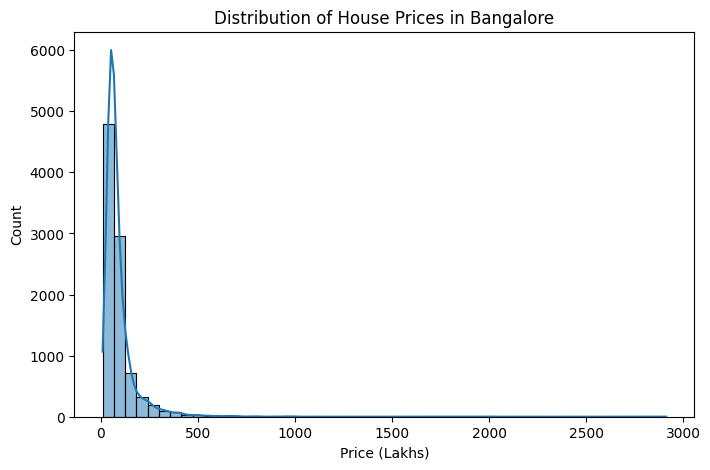

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.xlabel("Price (Lakhs)")
plt.title("Distribution of House Prices in Bangalore")
plt.show()


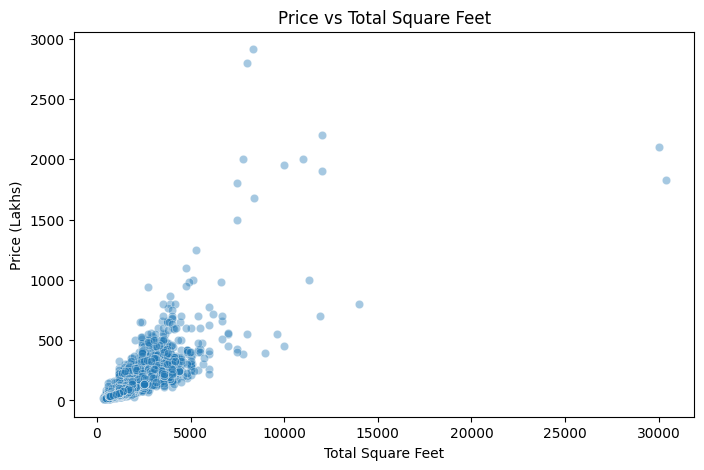

In [31]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['total_sqft'], y=df['price'], alpha=0.4)
plt.xlabel("Total Square Feet")
plt.ylabel("Price (Lakhs)")
plt.title("Price vs Total Square Feet")
plt.show()


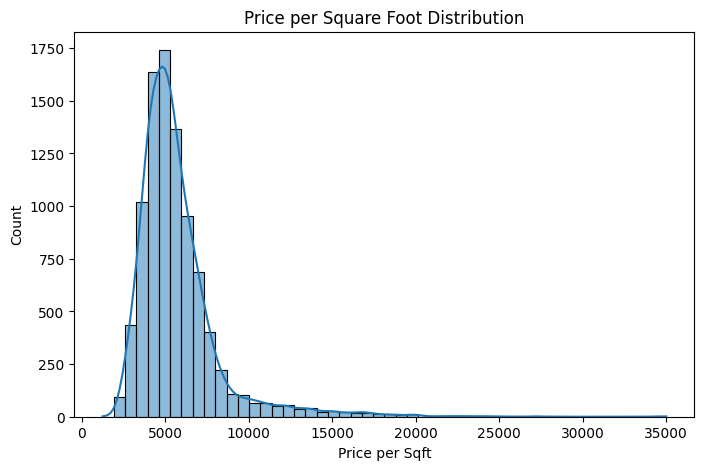

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(df['price_per_sqft'], bins=50, kde=True)
plt.xlabel("Price per Sqft")
plt.title("Price per Square Foot Distribution")
plt.show()


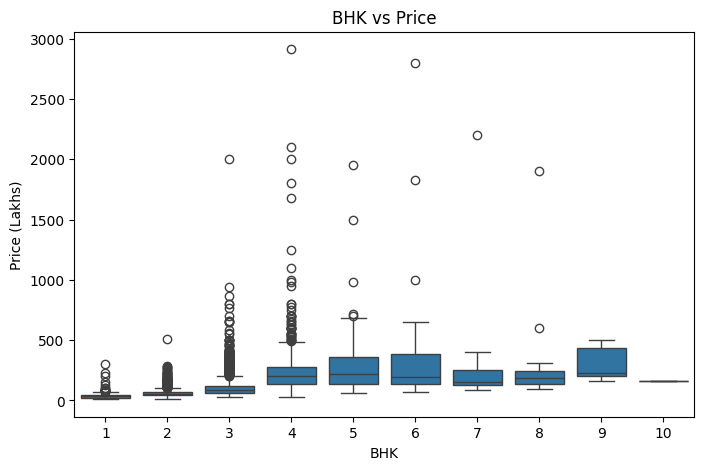

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(x='bhk', y='price', data=df)
plt.xlabel("BHK")
plt.ylabel("Price (Lakhs)")
plt.title("BHK vs Price")
plt.show()


I performed exploratory data analysis to understand price distributions, identify outliers, and validate relationships between area, BHK, and price. These insights guided my feature engineering and outlier removal strategy.

In [35]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


“I improved prediction stability by introducing feature scaling and Ridge regularization using a Scikit-learn pipeline.”

In [36]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])


In [37]:
pipeline.fit(X_train, y_train)


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [38]:
pipeline.score(X_test, y_test)


0.8803411444957195

Linear models produced invalid negative prices, so I switched to a Random Forest regressor to capture non-linear patterns and ensure realistic predictions.”

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
rf_model.score(X_test, y_test)


0.9621612257199267

In [43]:
import pickle, json

pickle.dump(rf_model, open("../model/model.pkl", "wb"))
json.dump(X.columns.tolist(), open("../model/columns.json", "w"))
